In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = str(most_recent_date)[2:-3]
print(most_recent_date)
# Calculate the date 1 year ago from from most recent date in database
a_year_from_recent = str(eval(most_recent_date[0:4])-1) + most_recent_date[4:]
print(a_year_from_recent)

2017-08-23
2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores & sort the dataframe by date
a_year_prcp = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= a_year_from_recent).filter(Measurement.date <= most_recent_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column  
a_year_prcp_df = pd.DataFrame(data=a_year_prcp)
a_year_prcp_df.set_index("date", inplace=True)
a_year_prcp_df.rename(columns={"prcp": "Percipitation"}, inplace=True)
a_year_prcp_df

,Percipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


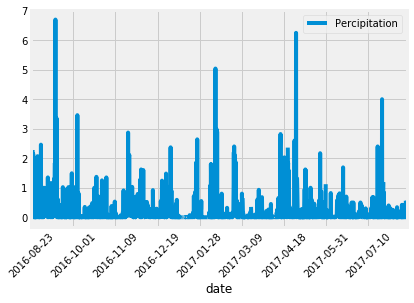

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data & Rotate the xticks for the dates
a_year_prcp_df.plot()
plt.xticks(rotation=45)
plt.savefig("prcp_analysis.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
a_year_prcp_df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
# station = inspector.get_columns('station')
# for column in station:
#     print(column["name"], column["type"])
station_count_query = session.query(Measurement.station).distinct().count()
station_count_query


9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.tobs))\
                    .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for station in most_active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = most_active_stations[0][0]
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station)

temperatures_stats = list(temperatures)
print(temperatures_stats)

[(54.0, 85.0, 71.66378066378067)]


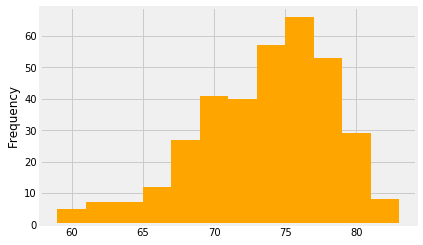

In [46]:
# Choose the station with the highest number of temperature observations.

highest_temp = session.query(Measurement.tobs)\
            .filter(Measurement.station == most_active_station)\
            .filter(Measurement.date <= most_recent_date)\
            .filter(Measurement.date >= a_year_from_recent)\
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_temp_list = []
for tobs in highest_temp:
    highest_temp_list.append(tobs[0])

plt.figure()
plt.hist(highest_temp_list, bins=12, label = "tobs", color="orange")
plt.ylabel("Frequency")
plt.savefig("Station_Temp_observ.png")
plt.show()


In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
    
### Trip dates: 8/1/17 - 8/16/17
    
print(calc_temps('2016-08-01', '2016-08-16'))


[(71.0, 78.15384615384616, 83.0)]


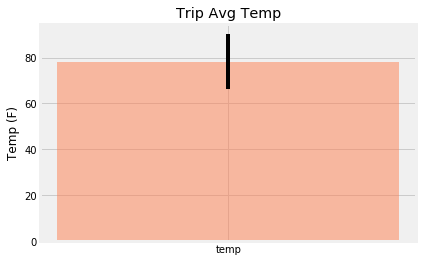

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

t_stats = calc_temps('2016-08-01', '2016-08-16')

t_yaxis = t_stats[0][1]
tmin = t_stats[0][0]
tmax = t_stats[0][2]
error = [tmax - tmin]

fig, plt.bar("temp", t_yaxis, alpha=.5, color="coral", align = "center", yerr = error, width=.01)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

plt.savefig("temp_analysis.png")
plt.show()

In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall_query = engine.execute('SELECT measurement.station, name, latitude, longitude, elevation, AVG(prcp) FROM measurement \
LEFT JOIN station ON measurement.station = station.station \
WHERE date BETWEEN "2016-08-23" AND "2017-08-23" GROUP BY measurement.station ORDER BY AVG(prcp) DESC').fetchall()
total_rainfall_query



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45064024390243923),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.19894886363636372),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.14142857142857151),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12543396226415093),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.12105095541401273),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.044818941504178235)]